There has been an increasing interest in multimodal imaging techniques that exploit the assets of multiple modalities jointly. In the microscopy domain, light microscopy (LM) and electron microscopy (EM) can be combined such that functional information (obtained by LM) can be combined with contextual high resolution ultrastructural visualization (obtained by EM). This multimodal microscopy approach is called correlative light and electron microscopy (CLEM). 

To optimally take advantage of this multimodal technique, the image modalities need to be aligned using a technique called image registration. This is typically done in two steps: first a global, rough alignment is performed, followed by a local, refined alignment.

This work proposes a method to align a subset of challenging CLEM alignment problems where an initial alignment is potentially difficult to find. Our method bases its alignment on a structure nicely spread throughout tissues and that is stainable in LM: the blood vessels. It focuses on aligning the blood vessel medial axes rather than the contour. It combines a feature-based and intensity-based approach: first a set of potential global overlays is selected based on the blood vessel bifurcations present in the volume, small matrix computations. From this set a final overlay is selected based on an intensity similarity metric, large matrices.

<img src="overv2_apr25.png" width="800"/>

Let us first load in the different libraries: napari (for viewing the images and adding points and line layers. The LM images can be viewed in 3D while the EM images are too dense and can only be viewed in 2D slices), 3dtransforms (decompose an affine transformation matrix), opencv (matrix transformation), skimage (general image processing algorithms), sklearn (similarity metrics) and scipy (general image processing algorithms). 

In [7]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import napari
from itertools import permutations, combinations
import math
import random
import cv2
from scipy import spatial, ndimage, stats
from sklearn.metrics import confusion_matrix, mean_squared_error, cluster
from skimage.morphology import skeletonize, binary_erosion, binary_dilation, convex_hull_image
from collections import Counter
import os

In [2]:
np.set_printoptions(suppress=True)

In [2]:
#os.getcwd()
#!git clone https://github.com/yentlvdb/MedialAxisMapping.git
#cd C:\\Users\\yentl\\MedialAxisMapping

Cloning into 'MedialAxisMapping'...


In [13]:
from algorithm import *

In [19]:
em_ori = tiff.imread("data/ds3_EM.tif")
lm_ori = tiff.imread("data/ds3_LM_blv.tif")
lm_ori2 = tiff.imread("data/ds3_LM_nc.tif")

In [17]:
print(em_ori.shape)

(185, 369, 182)


Load in the images: EM image and 2-channel-LM (blood vessel and nucleus staining). The images are isotropic (resolution LM along the z axis), and view them in napari(LM 3D viewer, EM 2D viewer).

In [21]:
viewer_em_3d = napari.Viewer(ndisplay=2)
viewer_em_3d.add_image(em_ori)
viewer_lm_3d = napari.Viewer(ndisplay=3)
viewer_lm_3d.add_image(lm_ori, colormap='cyan')
viewer_lm_3d.add_image(lm_ori2, colormap='magenta')

<Image layer 'lm_ori2' at 0x26257408380>

The different steps of the algorithm for global alignment thus are (see the figure above):
1. create input: two graphs representing the underlying blood vessel pattern
   1. defining nodes and edges
   2. or use predefined input
   3. graph       
3. from these nodes all possible subsets of three = all triangles
   1. LM z axis: small
   2. thus 3 nodes, with 4th node on normal of plane formed by the 3 points
5. determine all pairs having a similar amount of edges: 0, 1 or 2
6. select all triangle pairs having minimal shear and scale components = selected candidates for intensity-based evaluation
7. select the transform having the highest similarity metric

# 1) Creating two graphs representing the underlying blood vessel pattern

By defining vessel bifurcations as junctions and interlying vessel segments as edges two spatial global graphs are created: $G_{EM} = (V_{EM}, E_{EM})$ and $G_{LM}= (V_{LM}, E_{LM})$, with $V_{EM}$ a set of m nodes $\{v_{EM,0}, v_{EM,1}, ..., v_{EM,m-1}\}$, with $v_{EM,i} = (x_{EM,i},y_{EM,i})$, a pixel in the EM image with coordinates $(x_i,y_i)$, and $E_{EM} \subseteq \{\{v_i,v_j\} \mid v_i,v_j \in V_{EM} \}$, a set of edges i.e. pairs of nodes. Similarly $V_{LM}$ a set of n nodes $\{v_{LM,0}, v_{LM,1}, ..., v_{LM,n-1}\}$, with $v_{LM,i} = (x_{LM,i},y_{LM,i})$, a pixel in the LM image with coordinates $(x_i,y_i)$, and $E_{LM} \subseteq \{\{v_i,v_j\} \mid v_i,v_j \in V_{LM} \}$.  

In the image stacks here 4 LM bifurcations can be identified in the LM image modality and 6 EM nodes in the EM image modality. Additionaly, 3 LM and 3 EM nodes are selected from the larger blood vessel running though the volumes. 

$V_{EM} = \{v_{EM,0}, ..., v_{EM,m-1}\}$

$V_{LM} = \{v_{LM,0}, ..., v_{LM,n-1}\}$

### defining nodes and edges

First we define the (bifurcation) nodes in both image modalities. We add an empty points layer and add nodes in the napari viewer in 2D modus. (Or go to the next subsection were sets of nodes and edges are predefined).

In [111]:
points_layer_lm = viewer_lm_3d.add_points([-10,-10,-10])
points_layer_em = viewer_em_3d.add_points([-10,-10,-10])

Now extract the added nodes from the viewer:

In [113]:
V_lm = points_layer_lm.data[1:]
V_em = points_layer_em.data[1:]

Next we define the present edges, blood vessel segments connecting the predefined nodes. In 2D lines can simply be drawn between nodes. However in 3D, this function does not exist (yet). We solve for this by immitating the line draw function by the pieces of code below. A new node layer is added, where nodes with subsequent odd and even indices are endnodes of an edge. 

In [115]:
# set text
text = {
    "string": "label",
    'size': 10,
    'color': 'orange',
}

#features = {'label': np.empty(0, dtype=int)}
features = {'label': np.array([0])}

# add (empty) points layer
points_layer = viewer_lm_3d.add_points([-10,-10,-10],
    features = features,
    name='points',
    size=30,
    edge_width=0.1,
    edge_width_is_relative=True,
    edge_color='orange',
    face_color='transparent',
    text=text,
)

# fire function to set point labels everytime points are added
@points_layer.events.data.connect
def set_point_labels():  
    global points_layer
    no_of_points = len(points_layer.data)
    points_layer.feature_defaults['label'] = no_of_points
    points_layer.properties["label"][0:no_of_points] = range(0, no_of_points)
    points_layer.text.values[0:no_of_points] = [str(i) for i in range(0, no_of_points)]

# fire function set_point_labels once at the start
set_point_labels()
    
# points layer ready for adding points after opening
points_layer.mode = 'add'

napari.run()

C:\Users\yentl\AppData\Local\Temp\ipykernel_16852\2829603116.py:12: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  points_layer = viewer_lm_3d.add_points([-10,-10,-10],
C:\Users\yentl\anaconda3\Lib\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_width_is_relative' is deprecated, please use 'border_width_is_relative' instead. The argument 'edge_width_is_relative' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  return func(*args, **kwargs)
C:\Users\yentl\anaconda3\Lib\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_color' is deprecated, please use 'border_color' instead. The argument 'edge_color' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  return func(*args, **kwargs)


In [126]:
E_lm = edges_from_edgepointlayer(points_layer, V_lm, projected=True)

And now similarly for the EM image:

In [130]:
# set text
text = {
    "string": "label",
    'size': 10,
    'color': 'orange',
}

#features = {'label': np.empty(0, dtype=int)}
features = {'label': np.array([0])}

# add (empty) points layer
points_layer = viewer_em_3d.add_points([-10,-10,-10],
    features = features,
    name='points',
    size=30,
    edge_width=0.1,
    edge_width_is_relative=True,
    edge_color='orange',
    face_color='transparent',
    text=text,
)

# fire function to set point labels everytime points are added
@points_layer.events.data.connect
def set_point_labels():  
    global points_layer
    no_of_points = len(points_layer.data)
    points_layer.feature_defaults['label'] = no_of_points
    points_layer.properties["label"][0:no_of_points] = range(0, no_of_points)
    points_layer.text.values[0:no_of_points] = [str(i) for i in range(0, no_of_points)]

# fire function set_point_labels once at the start
set_point_labels()
    
# points layer ready for adding points after opening
points_layer.mode = 'add'

napari.run()

C:\Users\yentl\AppData\Local\Temp\ipykernel_16852\3979256823.py:12: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  points_layer = viewer_em_3d.add_points([-10,-10,-10],
C:\Users\yentl\anaconda3\Lib\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_width_is_relative' is deprecated, please use 'border_width_is_relative' instead. The argument 'edge_width_is_relative' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  return func(*args, **kwargs)
C:\Users\yentl\anaconda3\Lib\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_color' is deprecated, please use 'border_color' instead. The argument 'edge_color' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  return func(*args, **kwargs)


In [132]:
E_em = edges_from_edgepointlayer(points_layer, V_em, projected=False)

### or predefined nodes and edges

In [42]:
V_lm= np.array([[30, 362, 436],
        [38, 396, 94],
        [40, 402, 187],
        [30, 444, 367],
        [28, 232, 155],
        [27, 130, 281],
        [28, 191, 6]])//2
E_lm = [[6, 4], [4, 5], [1, 2], [2, 3], [3, 0]]

V_em = np.array([[144, 28, 43],
        [146, 28, 123],
        [221, 676, 134],
        [240, 501, 332],
        [237, 549, 285],
        [201, 336, 352],
        [199, 207, 254],
        [177, 205, 85],
        [99, 625, 100]])//2
E_em = [[7, 6], [5, 6], [0, 1], [2, 4], [3, 4]]

### now we can create graph instances from these nodes and edges

In [47]:
label_and_view_points(V_lm,viewer_lm_3d)
view_edges(E_lm, V_lm, viewer_lm_3d)

label_and_view_points(V_em,viewer_em_3d)
view_edges(E_em, V_em, viewer_em_3d)

In [44]:
# graph instance nu obv nodes niet edges
G_em = Graph(V_em, E_em)
G_lm = Graph(V_lm, E_lm)

In [94]:
print(G_lm.nodes)

{0: {'index': 0, 'z': 15, 'y': 181, 'x': 218}, 1: {'index': 1, 'z': 19, 'y': 198, 'x': 47}, 2: {'index': 2, 'z': 20, 'y': 201, 'x': 93}, 3: {'index': 3, 'z': 15, 'y': 222, 'x': 183}, 4: {'index': 4, 'z': 14, 'y': 116, 'x': 77}, 5: {'index': 5, 'z': 13, 'y': 65, 'x': 140}, 6: {'index': 6, 'z': 14, 'y': 95, 'x': 3}}


# 2) Generation of all subsets of three nodes

In 3D space, finding an affine transformation matrix thus corresponds with finding four paired not linearly dependent points. Since the LM modality is rather 'thin' (z dimension is significantly smaller than x and y dimensions), the fourth point contains no extra information since it is lying in the plane described by the other three points. As a solution, three points are sufficient to estimate an affine transform, assuming no scaling or shearing in the direction perpendicular to the plane containing the three points. The fourth point is calculated as lying on a fixed distance on the normal, defined as $\overrightarrow{n} = \overrightarrow{p_{0} p_{1}} \times \overrightarrow{p_{0} p_{2}}$, of the plane, added to the center of the triangle formed by the three other nodes.

From both sets of nodes $V_{EM}$ and $V_{LM}$ subsets of 3 nodes are considered: $S_{lm} = \{[0,1,2],[0,1,3],...,[n-2,n-1,n]\}$ and
$S_{em} = \{[0,1,2],[0,1,3],...,[m-2,m-1,m]\}$, with m the amount of LM nodes and n the amount of EM nodes. There are thus $\binom{m}{3} = \frac{m!}{3!(m-3)!}$ and $\binom{n}{3} = \frac{n!}{3!(n-3)!}$ of those subsets of EM nodes and LM nodes respectively.

In [56]:
S_em = G_em.get_all_subsets_of_three_nodes() 
S_lm = G_lm.get_all_subsets_of_three_nodes()
print("There are %r EM triangles and %r LM triangles." % (len(S_em), len(S_lm)))

There are 84 EM triangles and 35 LM triangles.


Let us visualize a random triangle in the LM image:

In [282]:
idx = random.randint(0,len(S_lm))
visualize_triangle(S_lm[idx], V_lm, viewer_lm_3d)

(1, 2, 5)


# 3) Pairs of triangles with similar edge counts

These subsets of 3 points are then matched. A majority of the triangle pairs correspond with physiologically impossible deformations, and should be filtered out. This is done on two levels. On a first level all triangle pairs that have a different amount of edges in their subgraphs are filtered out.
Triangle pairs having the same amount of edges are selected for further evaluation.

The presence of one or two edges results in one paired node, and thus two possible permutations to evaluate. The presence of no edges results in no paired nodes and thus all 6 possible permutations to evaluate.
Since the amount of LM triangles is high we will only consider triangles having one edge or two edges, since triangles having zero (or three) edges result in more possible permutations than triangles having one edge or two edges (respectively 6 and 2 permutations).

In [58]:
min_amount = 1
paired_triangles_based_on_edge_count = find_matching_subsets(G_em, G_lm, min_amount)
print("There are %r paired triangles having the same amount of edges with a minimum of %r edge(s)." % (len(paired_triangles_based_on_edge_count),min_amount))

There are 595 paired triangles having the same amount of edges with a minimum of 1 edge(s).


There are 1682 triangles that do not match with respect to edge count. 663, 589 and 6 do match with respectively 0, 1 and 2 edges.


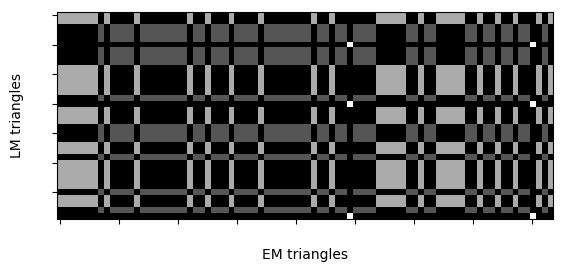

In [60]:
matrix = matching_subsets_edgecountmatrix(G_lm, G_em)
plt.imshow(matrix, cmap='grey')
#plt.axis('off')
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel("EM triangles")
plt.ylabel("LM triangles")
unique, counts = np.unique(matrix, return_counts=True)
print("There are %r triangles that do not match with respect to edge count. %r, %r and %r do match with respectively 0, 1 and 2 edges." % (counts[0], counts[1], counts[2], counts[3]))

# 4) Physiologically possible affine transformations should have minimal shear and scale components

For each subset we now add a fourth point on the normal, defined as $\overrightarrow{n} = \overrightarrow{p_{0} p_{1}} \times \overrightarrow{p_{0} p_{2}}$, of the plane formed by the three other nodes. Now every tetrahedron pair corresponds with an affine transformation. Again the majority of these affine transformation correspond with physiologically impossible deformations, and should be filtered out. On this second level this is done by decomposing the affine transformation matrices into separate translation, rotation, shear and scale matrices. 

$A = T \cdot R \cdot Z \cdot S$ 

With $A$ an affine transformation mapping point $(z,y,x)$ on point $(z',y',x')$:

$\begin{pmatrix}
   z' \\
   y' \\
   x' \\
   1 \\
   \end{pmatrix}
 =
 \begin{pmatrix}
   A_{11}  & A_{12} & A_{13} & t_z\\
   A_{21}  & A_{22} & A_{23} & t_y\\
   A_{31}  & A_{32} & A_{33} & t_x\\
   0 & 0 & 0 & 1\\
   \end{pmatrix}
 \cdot 
 \begin{pmatrix}
   z \\
   y \\
   x \\
   1 \\
   \end{pmatrix}$

Since $A$ is written in homogeneous coordinates such that a translation can be written as a matrix multiplication, $T$ can be straightforwardly extracted from $A$, and:

$\begin{pmatrix}
   A_{11}  & A_{12} & A_{13} \\
   A_{21}  & A_{22} & A_{23} \\
   A_{31}  & A_{32} & A_{33} \\
   \end{pmatrix}
 =
 \begin{pmatrix}
   R_{11}  & R_{12} & R_{13} \\
   R_{21}  & R_{22} & R_{23} \\
   R_{31}  & R_{32} & R_{33} \\
   \end{pmatrix}
 \begin{pmatrix}
   1  & sh_{zy} & sh_{zx}\\
   0  & 1 & sh_{yx} \\
   0 & 0 & 1 \\
   \end{pmatrix}
 \begin{pmatrix}
   sc_z  & 0 & 0 \\
   0  & sc_y & 0 \\
   0 & 0 & sc_x \\
   \end{pmatrix}$

$R$ is a rotation matrix, and is thus orthogonal with $R \cdot R^T = I_3$

If we now compute $B = (R \cdot Z \cdot S)^T \cdot (R \cdot Z \cdot S) = R^T \cdot R \cdot (Z \cdot S)^T \cdot (Z \cdot S) = I_3 \cdot (Z \cdot S)^T \cdot (Z \cdot S) = (Z \cdot S)^T \cdot (Z \cdot S)$

Since $Z$ is a diagonal matrix and $S$ is an upper triangular matrix, then the Cholesky decomposition of $B$ into a lower triangular matrix and its transpose: $B = L \cdot L^T$ with $L^T = (Z \cdot S)$ and $L = (Z \cdot S)^T$ straightforwardly gives us $Z$ and $S$.

Physiologically possible transformations should have shear and scale matrices close enough to the identity matrix, thus minimal shearing and scaling. All tetrahedron pairs deviating beyond a predefined threshold should be filtered out.

In [167]:
all_aff_tfm, corresponding_pairs = filter_by_shear_and_scale(paired_triangles_based_on_edge_count, G_lm, G_em, scale_thr=1.5, shear_thr=0.1)
print("There are %r tetrahedon pairs left." % (len(all_aff_tfm)))

There are 14 tetrahedon pairs left.


compared with figure edge matching

Text(0.5, 0, 'EM triangles')

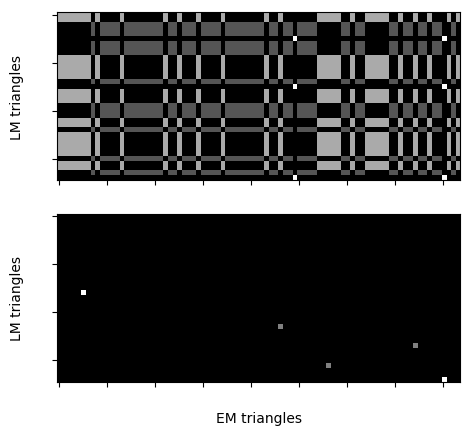

In [207]:
matrix2 = matching_tetrahedrons(S_lm, S_em, corresponding_pairs)
ax1 = plt.subplot(2,1, 1)
ax1.imshow(matrix, cmap='grey')
plt.xticks(color='white')
plt.yticks(color='white')
plt.ylabel("LM triangles")
ax2 = plt.subplot(2,1, 2)
ax2.imshow(matrix2, cmap='grey')
plt.xticks(color='white')
plt.yticks(color='white')
plt.ylabel("LM triangles")
plt.xlabel("EM triangles")

# 5) 5) Intensity-based search of the selected candidate affine transformation matrices

The LM image is then transformed by the remaining, candidate affine transformations and the similarity is calculated between the EM image and the transformed LM image. The similarity metric of choice is the mutual information. Mutual information between two images describes how much information of one image is contained in the other image, or thus how the pixel-wise intensity values in one image can predict the pixel-wise intensity values in the other image. The higher this value is, the better the two images are aligned. Normalized mutual information (NMI) is calculated as:

\begin{equation}
NMI(img_1,img_2) = \sum_{i_2 \in img_2} \sum_{i_1 \in img_1} p(i_1,i_2) \log \frac{p(i_1,i_2)}{p(i_1) p(i_2)}
\end{equation}

with $p(i_1,i_2)$ the joint histogram and $p(i_1)$ and $p(i_2)$ the individual histograms. The NMI is thus high when the signal in the joint histogram is highly concentrated in a small number of bins. Incorporation of the individual histograms normalizes the mutual information to values between 1 (low similarity) to 2 (high similarity).

In [219]:
optimal_aff_tfm, corresponding_pair = affine_transformation_with_highest_nmi(lm_ori, em_ori, all_aff_tfm, corresponding_pairs)

In [228]:
out = ndimage.affine_transform(lm_ori, optimal_aff_tfm, output_shape=em_ori.shape)
viewer_em_3d.add_image(out, colormap='cyan', opacity=0.5)

<Image layer 'out [1]' at 0x1e95b3cfec0>

And this transformation corresponds with the triangle pair:

In [233]:
visualize_triangle(corresponding_pair[1][:3], V_lm, viewer_lm_3d)
visualize_triangle(corresponding_pair[0][:3], V_em, viewer_em_3d)

[[7, 0, 1, 50], [4, 2, 1, -50]]
[4, 2, 1]
[7, 0, 1]
